In [1]:
import pandas as pd
import numpy as np
import glob,os
import xlrd
data='../data/'
n=6

In [2]:
#get gene lists
gen=pd.read_csv(data+'clean/genes.csv',index_col=0)
gen.shape

(18937, 1)

In [3]:
#load and clean RNA data

In [4]:
##mesa
meta_=data+'input/cohorts/mesa/phs001416.v3.pht010512.v1.p1.c1.TOPMed_MESA_RNA_Seq_Expression_Sample_Attributes.HMB.txt'
meta=pd.read_table(meta_,skiprows=10,index_col='SAMPLE_ID')
meta=meta[meta['HISTOLOGICAL_TYPE']=='PBMC']
meta=meta[['AGE_AT_COLLECTION','COLLECTION_VISIT','SUBJECT_ID','ANALYTE_ISOLATION_BATCH_ID']]
meta.columns=['age','cohort','sid','phase']
meta=meta[meta['phase'].isin(['1','2','3','4','5'])].copy()
meta['cohort']=meta['cohort'].replace({1:'MESA1',5:'MESA2'})
meta=meta[['cohort','sid','age']].sort_values(['cohort','sid']).copy()
subj=pd.read_table(data+'input/cohorts/mesa/phs000209.v13.pht001116.v10.p3.c1.MESA_Exam1Main.HMB.txt',skiprows=10,index_col=0,usecols=['sidno','gender1'])
subj.columns=['sex']
meta=meta.merge(subj[['sex']],left_on='sid',right_index=True,how='inner')
meta.to_csv(data+'clean/cohorts/meta/mesa_rna.csv')
meta.shape

(1861, 4)

In [5]:
%%time
# create data pickles 
mesa_=data+'input/cohorts/mesa/TOPMed_MESA_RNAseq_Pilot_RSEMv1.3.0.rsem_genes_expected_count.txt'
mesa=pd.read_table(mesa_,index_col=0,nrows=10**n,usecols=[0]+list(range(2,2774)))
mesa['id']=mesa.index.str.split('.').str[0]
mesa=mesa.groupby('id').mean()
mesa=mesa[mesa.index.isin(gen.index)]
dta=mesa.T
dta=meta.join(dta,how='inner')
dt=dta[dta['cohort']=='MESA1']
dt.drop('cohort',axis=1).T.to_pickle(data+'clean/cohorts/rna/mesa1.pkl')
dt=dta[dta['cohort']=='MESA2']
dt.drop('cohort',axis=1).T.to_pickle(data+'clean/cohorts/rna/mesa2.pkl')
mesa.shape

CPU times: user 18 s, sys: 6.23 s, total: 24.2 s
Wall time: 24.9 s


(18830, 2772)

In [7]:
%%time
jen1_meta_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE103nnn/GSE103232/matrix/GSE103232_series_matrix.txt.gz'
jen1_meta=pd.read_table(jen1_meta_,index_col=0,skiprows=32)
jen1=pd.read_excel(data+'input/cohorts/jena/GSE103232_hs_blood_batch2_counts_rpkm.xls',index_col=0)
jen1=jen1[jen1.index.isin(gen.index)]
jen1=jen1.drop(['external_gene_id','description','gene_biotype'],axis=1)
jen1=jen1[jen1.sum(1)>0].T
age=jen1_meta.iloc[8].str[5:7].astype(int)
age.index=age.index.str[-3:]
jen1=jen1.join(age.rename('age'))
jen2_meta_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75337/matrix/GSE75337_series_matrix.txt.gz'
jen2_meta=pd.read_table(jen2_meta_,index_col=0,skiprows=34)
jen2=pd.read_excel(data+'input/cohorts/jena/GSE75337_counts_RPKMs.xls',index_col=0)
jen2=jen2[jen2.index.isin(gen.index)]
jen2.columns=jen2.columns.str.strip(' ')
jen2=jen2.drop(['external_gene_id','description','gene_biotype'],axis=1)
jen2=jen2[[c for c in jen2.columns if 'blood' in c]]
jen2=jen2[jen2.sum(1)>0].T
age2=jen2_meta.iloc[8].str[5:7].astype(int)
jen2=jen2.merge(age2.rename('age'),left_index=True,right_index=True)
jen=pd.concat([jen1,jen2],ignore_index=True,join='inner').copy()
jen['sex']=2
jen.T.to_pickle(data+'clean/cohorts/rna/jena.pkl')
jen.shape

CPU times: user 15.9 s, sys: 789 ms, total: 16.7 s
Wall time: 17.2 s


(62, 16847)

In [36]:
%%time
##gc6
meta_=data+'input/cohorts/gc6/GSE94438_series_matrix.txt'
meta=pd.read_table(meta_,index_col=0,skiprows=33).iloc[[7,10,11,12]].T
meta.columns=['id','age','sex','group']
meta['sex']=meta['sex'].replace({'gender: F':0,'gender: M':1})
meta=meta[meta['group']=='group: Control'].copy()
meta['age']=meta['age'].str.strip('age: ')
meta['age']=pd.to_numeric(meta['age'], errors='coerce')
meta.index='X'+meta['id'].str.strip('code: : ')
gc=pd.read_csv(data+'input/cohorts/gc6/GSE94438_rawCounts_GeneNames_AllSamples.csv',index_col=0)
gc=gc[gc.index.isin(gen.index)]
gc=gc.drop('symbol',axis=1)
dt=meta[['age','sex']].join(gc.T).astype(float)
dt.T.to_pickle(data+'clean/cohorts/rna/gc6.pkl')
dt.shape

CPU times: user 922 ms, sys: 76.1 ms, total: 998 ms
Wall time: 1.41 s


(327, 13512)

In [9]:
%%time
##dutch
meta_='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE134nnn/GSE134080/matrix/GSE134080_series_matrix.txt.gz'
meta=pd.read_table(meta_,skiprows=30).drop('!Sample_title',axis=1).iloc[10:12].T
meta.columns=['age','sex']
meta['age']=meta['age'].str.strip('age: ').astype(int)
meta['sex']=meta['sex'].replace({'Sex: female':0,'Sex: male':1})
meta.index=meta.index.str.strip('Dutch 500FG cohort, whole blood, individual ')
fg=pd.read_csv(data+'input/cohorts/dutch/GSE134080_500FG_RNASeq_counts.txt',index_col=0)
fg=fg[fg.index.isin(gen.index)]
dt=fg.T.join(meta,how='inner')
dt.T.to_pickle(data+'clean/cohorts/rna/dutch.pkl')
fg.shape

<timed exec>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


CPU times: user 427 ms, sys: 43.8 ms, total: 470 ms
Wall time: 1 s


(17415, 100)

In [10]:
%%time
#ppmi
meta=pd.read_excel(data+'input/cohorts/ppmi/PPMI_Curated_Data_Cut_Public_20240129.xlsx',sheet_name='20240129')
meta=meta[meta['EVENT_ID']=='BL']
meta.index=meta['PATNO'].astype(str)
meta=meta[['age_at_visit','SEX','visit_date']]
meta.columns=['age','sex','visit_date']
meta.to_csv(data+'clean/cohorts/meta/ppmi.csv')

CPU times: user 7.01 s, sys: 122 ms, total: 7.13 s
Wall time: 7.22 s


In [11]:
%%time
path=data+'input/cohorts/ppmi/rna/'
all_files = glob.glob(os.path.join(path, "*.sf"))
df = pd.concat((pd.read_table(f,sep=' ') for f in all_files), ignore_index=True)
ss=[]
for f in all_files:
    s=f.split('IR3.')[1].split('.BL')[0]
    ss.append(s)
df['s']=np.repeat(ss,58294)    
dfw=df.pivot(index='s',columns='Name')
dfw.columns=[c[1] for c in dfw.columns]

CPU times: user 1min 44s, sys: 40.9 s, total: 2min 24s
Wall time: 2min 25s


In [12]:
dt=dfw.T
dt['id']=dt.index.str.split('.').str[0]
dt=dt.groupby('id').mean()
dt=dt[dt.index.isin(gen.index)]
dt=meta.drop('visit_date',axis=1).join(dt.T,how='inner')
dt.T.to_pickle(data+'clean/cohorts/rna/ppmi.pkl')
dt.shape

(1111, 18852)

In [13]:
ages=[]
cd248s=[]
dic={'mesa1':'MESA1','mesa2':'MESA2','ppmi':'PPMI','gc6':'GC6','dutch':'Dutch','jena':'JenAge'}
for rna_ in ['mesa1','mesa2','ppmi','gc6','dutch','jena']:
    rna=pd.read_pickle(data+'clean/cohorts/rna/'+rna_+'.pkl')
    cd248=rna.loc[['ENSG00000174807','age']].T
    cd248['cohort']=dic[rna_]
    cd248s.append(cd248)
    age_sex=rna.loc[['age','sex']].T
    age_sex['cohort']=dic[rna_]
    ages.append(age_sex)
ages=pd.concat(ages)
cd248s=pd.concat(cd248s)
ages['sex']=ages['sex'].replace({0:'Female',1:'Male',2:'Unknown'})
ages.to_csv(data+'result/rna_age.csv')    
cd248s.rename(columns={'ENSG00000174807':'CD248'}).to_csv(data+'result/cd248.csv')    

<Axes: xlabel='cohort', ylabel='age'>

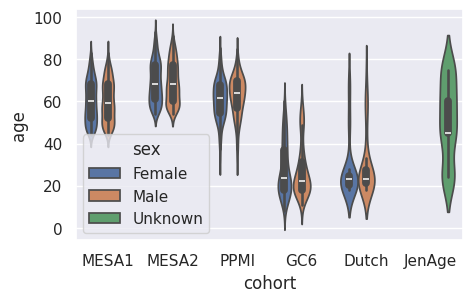

In [14]:
import seaborn as sns
sns.set(rc={'figure.figsize':(5,3)})
sns.violinplot(data=ages.reset_index(),x='cohort',y='age',hue='sex',order=['MESA1','MESA2','PPMI','GC6','Dutch','JenAge'])

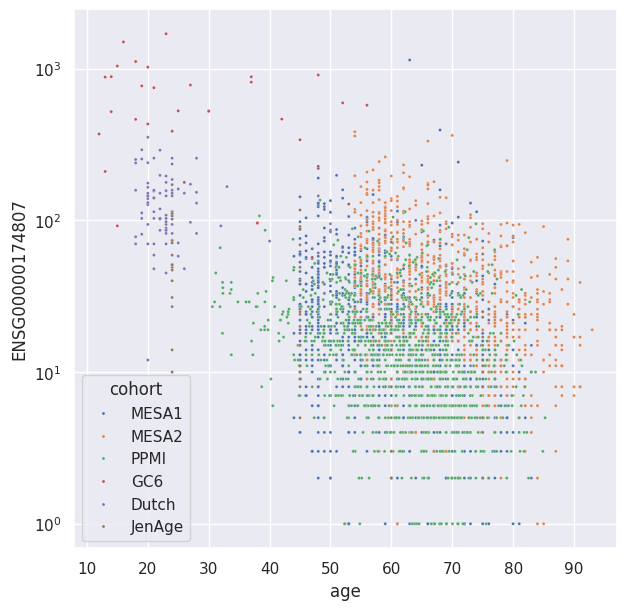

In [15]:
sns.set(rc={'figure.figsize':(7,7)})
ax=sns.scatterplot(data=cd248s.reset_index(),x='age',y='ENSG00000174807',hue='cohort',hue_order=['MESA1','MESA2','PPMI','GC6','Dutch','JenAge'],s=5);
ax.set(yscale='log');